# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

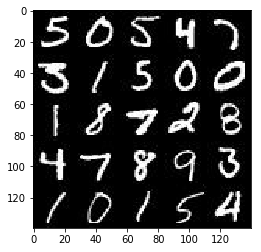

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

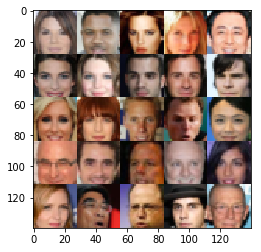

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name = 'inputs_Z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Implementation: 
    ## Define an alpha variable & set a low value. 
    alpha = 0.01
    ## Set a variable scope of discriminator
    with tf.variable_scope('discriminator', reuse = reuse):
        ## input layer is 28 * 28 * 3
        
        ## first convolutional layer with leaky relu
        ## don't use batch normalization in first layer of discriminator
        img1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        l_relu1 = tf.maximum(alpha*img1, img1)
        ## output is 14 * 4* 56
        
        ## second convolutional layer with batch normaliztion & leaky relu
        img2 = tf.layers.conv2d(l_relu1, 128, 5, strides = 2, padding = 'same')
        img2 = tf.layers.batch_normalization(img2, training = True)
        l_relu2 = tf.maximum(alpha*img2, img2)
        ## output is 7 * 7 * 112
        
        ## third convolutional layer with batch normalization & leaky relu
        img3 = tf.layers.conv2d(l_relu2, 256, 5, strides = 2, padding = 'same')
        img3 = tf.layers.batch_normalization(img3, training = True)
        l_relu3 = tf.maximum(alpha*img3, img3)
        ## output is 4 * 4 * 224 (really 3.5 * 3.5 * 224)
        
        ## flatten the layer 
        flat = tf.reshape(l_relu3, (-1, 4*4*256))
        ## get the logits
        logits = tf.layers.dense(flat, 1, activation=None)
        ## get the sigmoid output
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # Implementation:
    ## Define the alpha & reuse since they are not passed in as params. 

    ## Generate a fully connected layer
    ## Reshape image to start off the convolutional stack & apply batch normalization
    ## Generate 2 convolutional layers with batch normalization & leaky relus
    ## Generate output layer (convolutional layer) and apply tanh to squash values between -1 to 1
    with tf.variable_scope('generator', reuse = not is_train):
        alpha = 0.01

        #First fully connected layer
        img1 = tf.layers.dense(z, 7*7*512)
        #Reshape
        img1 = tf.reshape(img1, (-1, 7, 7, 512))
        img1 = tf.layers.batch_normalization(img1, training=is_train)
        #print(img1.get_shape().as_list())
        l_relu1 = tf.maximum(alpha * img1, img1)
        #print(l_relu1.get_shape().as_list())
        
        #Convolutional layer
        img2 = tf.layers.conv2d_transpose(l_relu1, 256, 5, strides = 2, padding = 'same')
        #print(img2.get_shape().as_list())
        img2 = tf.layers.batch_normalization(img2, training = is_train)
        l_relu2 = tf.maximum(alpha*img2, img2)
        #print(l_relu2.get_shape().as_list())
        
        #Convolutional layer
        img3 = tf.layers.conv2d_transpose(l_relu2, 128, 5, strides = 2, padding = 'same')
        img3 = tf.layers.batch_normalization(img3, training = is_train)
        l_relu3 = tf.maximum(alpha * img3, img3)
        print(l_relu3.get_shape().as_list())


        
        #Output layer
        logits = tf.layers.conv2d_transpose(l_relu3, out_channel_dim, 5, strides = 1, padding = 'same')
        #print(out_channel_dim)
        #print(logits.get_shape().as_list())


        
        out = tf.tanh(logits)
        
        return out
        
        

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

[None, 28, 28, 128]
[None, 28, 28, 128]
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    #Implementation: 

    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels = tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels = tf.zeros_like(d_model_fake))) 
    
    g_loss= tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels = tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

[None, 28, 28, 128]
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    
    real_input, z_input, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    print_interval = 10
    show_interval = 100
    n_images = 16
    steps = 0
    losses = []
               
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_input: z_sample, real_input: batch_images})
                _ = sess.run(g_train_opt, feed_dict={z_input: z_sample, real_input: batch_images})
                
                if steps % print_interval == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}\t".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}\t".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_interval == 0:
                    show_generator_output(sess, n_images, z_input, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

[None, 28, 28, 128]
Epoch 1/2	 Discriminator Loss: 7.5401	 Generator Loss: 0.0042
Epoch 1/2	 Discriminator Loss: 1.5784	 Generator Loss: 0.4196
Epoch 1/2	 Discriminator Loss: 2.1902	 Generator Loss: 0.2315
Epoch 1/2	 Discriminator Loss: 1.6151	 Generator Loss: 0.7629
Epoch 1/2	 Discriminator Loss: 1.7642	 Generator Loss: 0.3887
Epoch 1/2	 Discriminator Loss: 1.5728	 Generator Loss: 1.3694
Epoch 1/2	 Discriminator Loss: 1.7024	 Generator Loss: 0.4265
Epoch 1/2	 Discriminator Loss: 1.7285	 Generator Loss: 1.7922
Epoch 1/2	 Discriminator Loss: 1.8456	 Generator Loss: 2.5314
Epoch 1/2	 Discriminator Loss: 1.1416	 Generator Loss: 1.6129
[None, 28, 28, 128]


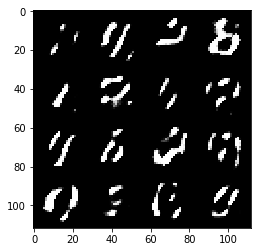

Epoch 1/2	 Discriminator Loss: 1.2209	 Generator Loss: 0.7030
Epoch 1/2	 Discriminator Loss: 1.3545	 Generator Loss: 0.9151
Epoch 1/2	 Discriminator Loss: 2.1157	 Generator Loss: 0.2289
Epoch 1/2	 Discriminator Loss: 1.5632	 Generator Loss: 0.6116
Epoch 1/2	 Discriminator Loss: 1.5500	 Generator Loss: 0.6052
Epoch 1/2	 Discriminator Loss: 1.4254	 Generator Loss: 0.8561
Epoch 1/2	 Discriminator Loss: 1.4871	 Generator Loss: 0.6921
Epoch 1/2	 Discriminator Loss: 1.5482	 Generator Loss: 0.8790
Epoch 1/2	 Discriminator Loss: 1.4198	 Generator Loss: 0.6275
Epoch 1/2	 Discriminator Loss: 1.4554	 Generator Loss: 0.6378
[None, 28, 28, 128]


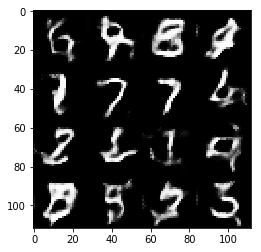

Epoch 1/2	 Discriminator Loss: 1.6886	 Generator Loss: 0.3562
Epoch 1/2	 Discriminator Loss: 1.5655	 Generator Loss: 0.4177
Epoch 1/2	 Discriminator Loss: 1.6362	 Generator Loss: 1.2232
Epoch 1/2	 Discriminator Loss: 1.4007	 Generator Loss: 0.8245
Epoch 1/2	 Discriminator Loss: 1.4919	 Generator Loss: 0.6170
Epoch 1/2	 Discriminator Loss: 1.4975	 Generator Loss: 0.6641
Epoch 1/2	 Discriminator Loss: 1.5506	 Generator Loss: 0.5381
Epoch 1/2	 Discriminator Loss: 1.4698	 Generator Loss: 0.5395
Epoch 1/2	 Discriminator Loss: 1.6142	 Generator Loss: 1.0796
Epoch 1/2	 Discriminator Loss: 1.4963	 Generator Loss: 0.9626
[None, 28, 28, 128]


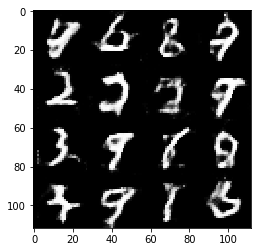

Epoch 1/2	 Discriminator Loss: 1.5282	 Generator Loss: 0.7595
Epoch 1/2	 Discriminator Loss: 1.7976	 Generator Loss: 0.3229
Epoch 1/2	 Discriminator Loss: 1.8345	 Generator Loss: 0.2895
Epoch 1/2	 Discriminator Loss: 1.6060	 Generator Loss: 0.7699
Epoch 1/2	 Discriminator Loss: 1.4343	 Generator Loss: 0.8364
Epoch 1/2	 Discriminator Loss: 1.4809	 Generator Loss: 0.6414
Epoch 1/2	 Discriminator Loss: 1.4527	 Generator Loss: 0.9618
Epoch 1/2	 Discriminator Loss: 1.6365	 Generator Loss: 0.3921
Epoch 1/2	 Discriminator Loss: 1.6252	 Generator Loss: 0.4017
Epoch 1/2	 Discriminator Loss: 1.7429	 Generator Loss: 0.3271
[None, 28, 28, 128]


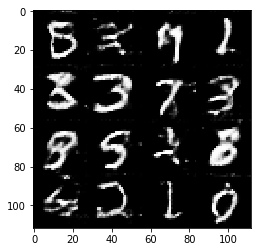

Epoch 1/2	 Discriminator Loss: 1.5780	 Generator Loss: 1.1586
Epoch 1/2	 Discriminator Loss: 1.7626	 Generator Loss: 0.3447
Epoch 1/2	 Discriminator Loss: 1.5308	 Generator Loss: 0.4934
Epoch 1/2	 Discriminator Loss: 1.5166	 Generator Loss: 1.1722
Epoch 1/2	 Discriminator Loss: 1.5140	 Generator Loss: 0.4753
Epoch 1/2	 Discriminator Loss: 1.4625	 Generator Loss: 1.1060
Epoch 1/2	 Discriminator Loss: 1.5789	 Generator Loss: 0.4381
Epoch 1/2	 Discriminator Loss: 1.8037	 Generator Loss: 0.3135
Epoch 1/2	 Discriminator Loss: 1.3962	 Generator Loss: 1.0180
Epoch 1/2	 Discriminator Loss: 1.6359	 Generator Loss: 0.4032
[None, 28, 28, 128]


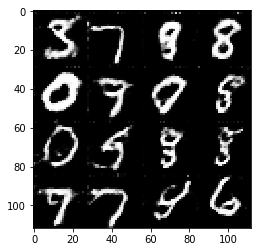

Epoch 1/2	 Discriminator Loss: 1.3777	 Generator Loss: 0.6691
Epoch 1/2	 Discriminator Loss: 1.5133	 Generator Loss: 0.7178
Epoch 1/2	 Discriminator Loss: 1.4507	 Generator Loss: 0.6877
Epoch 1/2	 Discriminator Loss: 1.9287	 Generator Loss: 0.2903
Epoch 1/2	 Discriminator Loss: 1.4912	 Generator Loss: 0.6222
Epoch 1/2	 Discriminator Loss: 1.5178	 Generator Loss: 0.6588
Epoch 1/2	 Discriminator Loss: 1.5893	 Generator Loss: 0.4444
Epoch 1/2	 Discriminator Loss: 1.4605	 Generator Loss: 0.9845
Epoch 1/2	 Discriminator Loss: 1.5948	 Generator Loss: 0.4741
Epoch 1/2	 Discriminator Loss: 1.5124	 Generator Loss: 0.6600
[None, 28, 28, 128]


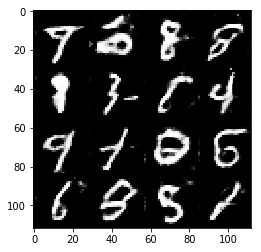

Epoch 1/2	 Discriminator Loss: 1.3001	 Generator Loss: 0.7945
Epoch 1/2	 Discriminator Loss: 1.5419	 Generator Loss: 0.4986
Epoch 1/2	 Discriminator Loss: 1.5909	 Generator Loss: 0.4255
Epoch 1/2	 Discriminator Loss: 1.6152	 Generator Loss: 0.4043
Epoch 1/2	 Discriminator Loss: 1.8354	 Generator Loss: 0.3046
Epoch 1/2	 Discriminator Loss: 1.4906	 Generator Loss: 0.5633
Epoch 1/2	 Discriminator Loss: 1.4773	 Generator Loss: 0.7290
Epoch 1/2	 Discriminator Loss: 1.5607	 Generator Loss: 0.4955
Epoch 1/2	 Discriminator Loss: 1.5079	 Generator Loss: 0.5686
Epoch 1/2	 Discriminator Loss: 1.6605	 Generator Loss: 0.9069
[None, 28, 28, 128]


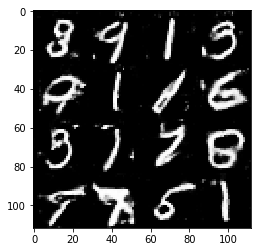

Epoch 1/2	 Discriminator Loss: 1.5034	 Generator Loss: 0.5829
Epoch 1/2	 Discriminator Loss: 1.4903	 Generator Loss: 0.6480
Epoch 1/2	 Discriminator Loss: 1.7254	 Generator Loss: 0.3511
Epoch 1/2	 Discriminator Loss: 1.8750	 Generator Loss: 0.2902
Epoch 1/2	 Discriminator Loss: 1.4114	 Generator Loss: 0.6565
Epoch 1/2	 Discriminator Loss: 1.8955	 Generator Loss: 0.2778
Epoch 1/2	 Discriminator Loss: 1.6988	 Generator Loss: 0.3749
Epoch 1/2	 Discriminator Loss: 1.5383	 Generator Loss: 0.5673
Epoch 1/2	 Discriminator Loss: 1.8112	 Generator Loss: 0.2940
Epoch 1/2	 Discriminator Loss: 1.6303	 Generator Loss: 0.4045
[None, 28, 28, 128]


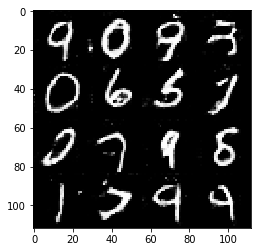

Epoch 1/2	 Discriminator Loss: 1.5465	 Generator Loss: 0.6055
Epoch 1/2	 Discriminator Loss: 1.5208	 Generator Loss: 0.4979
Epoch 1/2	 Discriminator Loss: 1.6302	 Generator Loss: 0.4014
Epoch 1/2	 Discriminator Loss: 1.8788	 Generator Loss: 0.2855
Epoch 1/2	 Discriminator Loss: 1.6695	 Generator Loss: 0.3858
Epoch 1/2	 Discriminator Loss: 1.5059	 Generator Loss: 0.5218
Epoch 1/2	 Discriminator Loss: 1.4090	 Generator Loss: 0.9221
Epoch 1/2	 Discriminator Loss: 1.5820	 Generator Loss: 0.4543
Epoch 1/2	 Discriminator Loss: 1.5325	 Generator Loss: 0.5012
Epoch 1/2	 Discriminator Loss: 1.4003	 Generator Loss: 0.6334
[None, 28, 28, 128]


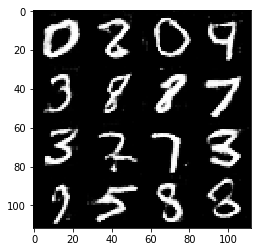

Epoch 1/2	 Discriminator Loss: 1.6869	 Generator Loss: 0.3819
Epoch 1/2	 Discriminator Loss: 1.6629	 Generator Loss: 1.4433
Epoch 1/2	 Discriminator Loss: 1.5519	 Generator Loss: 0.6243
Epoch 2/2	 Discriminator Loss: 1.6040	 Generator Loss: 0.4552
Epoch 2/2	 Discriminator Loss: 1.5827	 Generator Loss: 0.5736
Epoch 2/2	 Discriminator Loss: 1.4877	 Generator Loss: 0.5975
Epoch 2/2	 Discriminator Loss: 1.4576	 Generator Loss: 0.8137
Epoch 2/2	 Discriminator Loss: 1.9007	 Generator Loss: 0.2793
Epoch 2/2	 Discriminator Loss: 1.3974	 Generator Loss: 0.6596
Epoch 2/2	 Discriminator Loss: 1.5414	 Generator Loss: 0.5832
[None, 28, 28, 128]


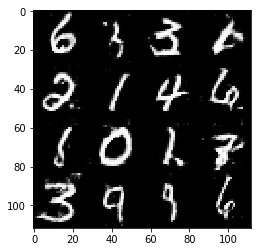

Epoch 2/2	 Discriminator Loss: 1.3874	 Generator Loss: 1.0504
Epoch 2/2	 Discriminator Loss: 1.6142	 Generator Loss: 0.4457
Epoch 2/2	 Discriminator Loss: 1.4999	 Generator Loss: 0.6150
Epoch 2/2	 Discriminator Loss: 1.6595	 Generator Loss: 0.4410
Epoch 2/2	 Discriminator Loss: 1.5929	 Generator Loss: 0.4351
Epoch 2/2	 Discriminator Loss: 1.5178	 Generator Loss: 0.5041
Epoch 2/2	 Discriminator Loss: 1.6357	 Generator Loss: 0.4019
Epoch 2/2	 Discriminator Loss: 1.4809	 Generator Loss: 0.8573
Epoch 2/2	 Discriminator Loss: 1.3884	 Generator Loss: 0.7447
Epoch 2/2	 Discriminator Loss: 1.4608	 Generator Loss: 0.7057
[None, 28, 28, 128]


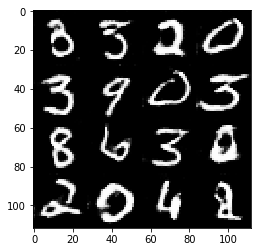

Epoch 2/2	 Discriminator Loss: 1.4408	 Generator Loss: 1.1089
Epoch 2/2	 Discriminator Loss: 1.3815	 Generator Loss: 0.7812
Epoch 2/2	 Discriminator Loss: 1.5242	 Generator Loss: 0.5751
Epoch 2/2	 Discriminator Loss: 1.3096	 Generator Loss: 0.8288
Epoch 2/2	 Discriminator Loss: 1.5324	 Generator Loss: 0.5060
Epoch 2/2	 Discriminator Loss: 1.3215	 Generator Loss: 0.8062
Epoch 2/2	 Discriminator Loss: 1.8184	 Generator Loss: 0.2936
Epoch 2/2	 Discriminator Loss: 1.3525	 Generator Loss: 0.6528
Epoch 2/2	 Discriminator Loss: 1.4532	 Generator Loss: 1.0154
Epoch 2/2	 Discriminator Loss: 1.5730	 Generator Loss: 1.3433
[None, 28, 28, 128]


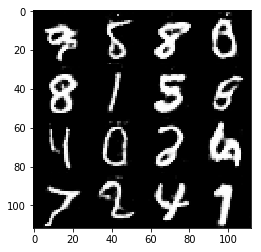

Epoch 2/2	 Discriminator Loss: 1.4666	 Generator Loss: 0.5160
Epoch 2/2	 Discriminator Loss: 1.5923	 Generator Loss: 0.4091
Epoch 2/2	 Discriminator Loss: 1.8003	 Generator Loss: 0.3463
Epoch 2/2	 Discriminator Loss: 1.4935	 Generator Loss: 0.5678
Epoch 2/2	 Discriminator Loss: 1.5911	 Generator Loss: 0.4489
Epoch 2/2	 Discriminator Loss: 1.4277	 Generator Loss: 0.6713
Epoch 2/2	 Discriminator Loss: 1.7172	 Generator Loss: 0.3976
Epoch 2/2	 Discriminator Loss: 1.5632	 Generator Loss: 0.4545
Epoch 2/2	 Discriminator Loss: 1.6307	 Generator Loss: 0.4348
Epoch 2/2	 Discriminator Loss: 1.4307	 Generator Loss: 0.6462
[None, 28, 28, 128]


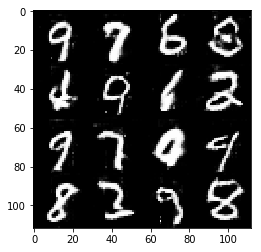

Epoch 2/2	 Discriminator Loss: 1.3369	 Generator Loss: 0.8365
Epoch 2/2	 Discriminator Loss: 1.8770	 Generator Loss: 0.2766
Epoch 2/2	 Discriminator Loss: 1.6462	 Generator Loss: 0.4148
Epoch 2/2	 Discriminator Loss: 2.1797	 Generator Loss: 0.2179
Epoch 2/2	 Discriminator Loss: 1.4529	 Generator Loss: 0.5550
Epoch 2/2	 Discriminator Loss: 1.3654	 Generator Loss: 0.6909
Epoch 2/2	 Discriminator Loss: 1.3894	 Generator Loss: 0.8358
Epoch 2/2	 Discriminator Loss: 1.5156	 Generator Loss: 0.4657
Epoch 2/2	 Discriminator Loss: 1.4000	 Generator Loss: 1.1688
Epoch 2/2	 Discriminator Loss: 1.5333	 Generator Loss: 0.5016
[None, 28, 28, 128]


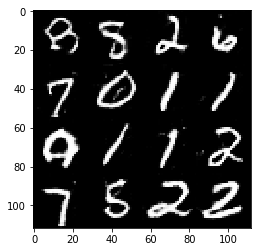

Epoch 2/2	 Discriminator Loss: 1.4061	 Generator Loss: 0.6728
Epoch 2/2	 Discriminator Loss: 1.5616	 Generator Loss: 0.5306
Epoch 2/2	 Discriminator Loss: 1.4319	 Generator Loss: 0.6278
Epoch 2/2	 Discriminator Loss: 1.4872	 Generator Loss: 0.6612
Epoch 2/2	 Discriminator Loss: 1.2493	 Generator Loss: 0.7257
Epoch 2/2	 Discriminator Loss: 1.3718	 Generator Loss: 0.8932
Epoch 2/2	 Discriminator Loss: 1.5536	 Generator Loss: 0.8256
Epoch 2/2	 Discriminator Loss: 1.3407	 Generator Loss: 0.9731
Epoch 2/2	 Discriminator Loss: 1.5846	 Generator Loss: 0.4955
Epoch 2/2	 Discriminator Loss: 1.4527	 Generator Loss: 0.8058
[None, 28, 28, 128]


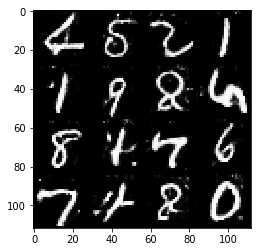

Epoch 2/2	 Discriminator Loss: 1.4756	 Generator Loss: 0.6334
Epoch 2/2	 Discriminator Loss: 1.4244	 Generator Loss: 0.6866
Epoch 2/2	 Discriminator Loss: 1.5077	 Generator Loss: 0.5172
Epoch 2/2	 Discriminator Loss: 1.1870	 Generator Loss: 0.9302
Epoch 2/2	 Discriminator Loss: 1.4519	 Generator Loss: 0.5543
Epoch 2/2	 Discriminator Loss: 1.4820	 Generator Loss: 0.6064
Epoch 2/2	 Discriminator Loss: 1.4625	 Generator Loss: 0.6954
Epoch 2/2	 Discriminator Loss: 1.6456	 Generator Loss: 0.4157
Epoch 2/2	 Discriminator Loss: 1.3772	 Generator Loss: 0.5547
Epoch 2/2	 Discriminator Loss: 1.8713	 Generator Loss: 0.2942
[None, 28, 28, 128]


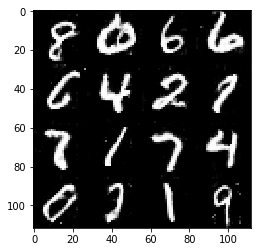

Epoch 2/2	 Discriminator Loss: 1.5767	 Generator Loss: 0.5251
Epoch 2/2	 Discriminator Loss: 1.4363	 Generator Loss: 0.5568
Epoch 2/2	 Discriminator Loss: 1.8998	 Generator Loss: 0.2657
Epoch 2/2	 Discriminator Loss: 1.3195	 Generator Loss: 0.7729
Epoch 2/2	 Discriminator Loss: 1.3105	 Generator Loss: 0.7586
Epoch 2/2	 Discriminator Loss: 1.2291	 Generator Loss: 0.6822
Epoch 2/2	 Discriminator Loss: 2.0360	 Generator Loss: 0.2387
Epoch 2/2	 Discriminator Loss: 1.4694	 Generator Loss: 0.9272
Epoch 2/2	 Discriminator Loss: 1.6262	 Generator Loss: 0.4124
Epoch 2/2	 Discriminator Loss: 1.3849	 Generator Loss: 0.9982
[None, 28, 28, 128]


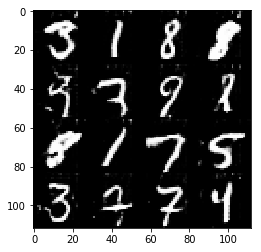

Epoch 2/2	 Discriminator Loss: 1.5518	 Generator Loss: 0.6915
Epoch 2/2	 Discriminator Loss: 2.2615	 Generator Loss: 0.1882
Epoch 2/2	 Discriminator Loss: 1.6731	 Generator Loss: 0.5628
Epoch 2/2	 Discriminator Loss: 1.4931	 Generator Loss: 0.6297
Epoch 2/2	 Discriminator Loss: 1.3565	 Generator Loss: 1.7488
Epoch 2/2	 Discriminator Loss: 1.3052	 Generator Loss: 0.7342
Epoch 2/2	 Discriminator Loss: 1.5023	 Generator Loss: 0.5256
Epoch 2/2	 Discriminator Loss: 1.6221	 Generator Loss: 0.4193
Epoch 2/2	 Discriminator Loss: 1.4666	 Generator Loss: 0.5346
Epoch 2/2	 Discriminator Loss: 1.7770	 Generator Loss: 0.3344
[None, 28, 28, 128]


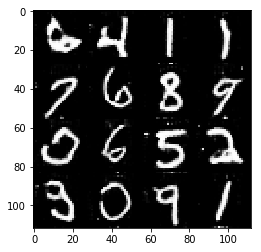

Epoch 2/2	 Discriminator Loss: 1.4007	 Generator Loss: 0.5356
Epoch 2/2	 Discriminator Loss: 1.5054	 Generator Loss: 0.4559
Epoch 2/2	 Discriminator Loss: 1.4919	 Generator Loss: 0.5403
Epoch 2/2	 Discriminator Loss: 1.5693	 Generator Loss: 0.4763
Epoch 2/2	 Discriminator Loss: 1.4645	 Generator Loss: 0.4735
Epoch 2/2	 Discriminator Loss: 1.5846	 Generator Loss: 0.4603
Epoch 2/2	 Discriminator Loss: 1.5670	 Generator Loss: 0.4540


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

[None, 28, 28, 128]
Epoch 1/1	 Discriminator Loss: 4.1481	 Generator Loss: 0.0287
Epoch 1/1	 Discriminator Loss: 3.3243	 Generator Loss: 0.0835
Epoch 1/1	 Discriminator Loss: 3.0744	 Generator Loss: 0.0840
Epoch 1/1	 Discriminator Loss: 2.0039	 Generator Loss: 0.4456
Epoch 1/1	 Discriminator Loss: 1.6755	 Generator Loss: 0.5171
Epoch 1/1	 Discriminator Loss: 1.6866	 Generator Loss: 0.6372
Epoch 1/1	 Discriminator Loss: 2.0778	 Generator Loss: 0.3570
Epoch 1/1	 Discriminator Loss: 1.8693	 Generator Loss: 0.3671
Epoch 1/1	 Discriminator Loss: 2.1250	 Generator Loss: 0.2750
Epoch 1/1	 Discriminator Loss: 1.8268	 Generator Loss: 0.4773
[None, 28, 28, 128]


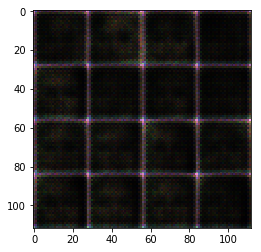

Epoch 1/1	 Discriminator Loss: 1.5245	 Generator Loss: 0.8475
Epoch 1/1	 Discriminator Loss: 1.7580	 Generator Loss: 0.4262
Epoch 1/1	 Discriminator Loss: 1.7795	 Generator Loss: 0.3688
Epoch 1/1	 Discriminator Loss: 1.8771	 Generator Loss: 0.4450
Epoch 1/1	 Discriminator Loss: 1.7036	 Generator Loss: 0.4409
Epoch 1/1	 Discriminator Loss: 1.7848	 Generator Loss: 0.3970
Epoch 1/1	 Discriminator Loss: 1.3798	 Generator Loss: 0.6967
Epoch 1/1	 Discriminator Loss: 1.7932	 Generator Loss: 0.4419
Epoch 1/1	 Discriminator Loss: 1.5306	 Generator Loss: 0.7378
Epoch 1/1	 Discriminator Loss: 1.7591	 Generator Loss: 0.4318
[None, 28, 28, 128]


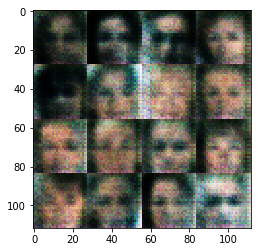

Epoch 1/1	 Discriminator Loss: 1.8678	 Generator Loss: 0.3843
Epoch 1/1	 Discriminator Loss: 2.1067	 Generator Loss: 0.3629
Epoch 1/1	 Discriminator Loss: 1.7899	 Generator Loss: 0.4286
Epoch 1/1	 Discriminator Loss: 1.3147	 Generator Loss: 0.7751
Epoch 1/1	 Discriminator Loss: 1.7588	 Generator Loss: 0.3849
Epoch 1/1	 Discriminator Loss: 1.2406	 Generator Loss: 0.6741
Epoch 1/1	 Discriminator Loss: 1.2527	 Generator Loss: 0.6643
Epoch 1/1	 Discriminator Loss: 1.3642	 Generator Loss: 0.7446
Epoch 1/1	 Discriminator Loss: 0.6932	 Generator Loss: 2.3337
Epoch 1/1	 Discriminator Loss: 2.0777	 Generator Loss: 0.3077
[None, 28, 28, 128]


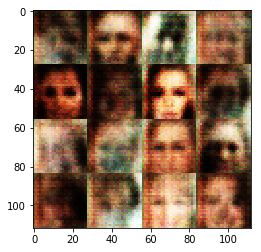

Epoch 1/1	 Discriminator Loss: 1.9732	 Generator Loss: 0.3081
Epoch 1/1	 Discriminator Loss: 2.0062	 Generator Loss: 0.3328
Epoch 1/1	 Discriminator Loss: 1.7869	 Generator Loss: 0.5433
Epoch 1/1	 Discriminator Loss: 1.2595	 Generator Loss: 1.3345
Epoch 1/1	 Discriminator Loss: 1.6473	 Generator Loss: 0.4948
Epoch 1/1	 Discriminator Loss: 1.7113	 Generator Loss: 0.4482
Epoch 1/1	 Discriminator Loss: 1.2324	 Generator Loss: 1.1599
Epoch 1/1	 Discriminator Loss: 1.7423	 Generator Loss: 0.4515
Epoch 1/1	 Discriminator Loss: 1.8194	 Generator Loss: 0.4961
Epoch 1/1	 Discriminator Loss: 1.5469	 Generator Loss: 0.7220
[None, 28, 28, 128]


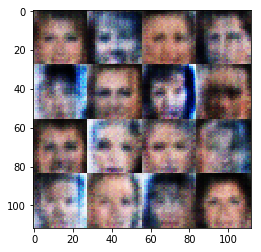

Epoch 1/1	 Discriminator Loss: 1.5246	 Generator Loss: 0.5567
Epoch 1/1	 Discriminator Loss: 1.5569	 Generator Loss: 0.5851
Epoch 1/1	 Discriminator Loss: 1.6150	 Generator Loss: 0.5411
Epoch 1/1	 Discriminator Loss: 1.7090	 Generator Loss: 0.5373
Epoch 1/1	 Discriminator Loss: 1.7967	 Generator Loss: 0.5066
Epoch 1/1	 Discriminator Loss: 1.8159	 Generator Loss: 0.4403
Epoch 1/1	 Discriminator Loss: 1.3517	 Generator Loss: 0.7563
Epoch 1/1	 Discriminator Loss: 1.3830	 Generator Loss: 0.8090
Epoch 1/1	 Discriminator Loss: 2.1016	 Generator Loss: 0.3171
Epoch 1/1	 Discriminator Loss: 1.6242	 Generator Loss: 0.5681
[None, 28, 28, 128]


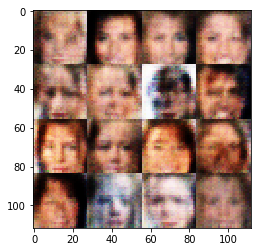

Epoch 1/1	 Discriminator Loss: 1.6141	 Generator Loss: 0.6529
Epoch 1/1	 Discriminator Loss: 1.7779	 Generator Loss: 0.3857
Epoch 1/1	 Discriminator Loss: 1.6545	 Generator Loss: 0.5402
Epoch 1/1	 Discriminator Loss: 1.6824	 Generator Loss: 0.5854
Epoch 1/1	 Discriminator Loss: 1.5483	 Generator Loss: 0.6397
Epoch 1/1	 Discriminator Loss: 1.6451	 Generator Loss: 0.6006
Epoch 1/1	 Discriminator Loss: 1.5902	 Generator Loss: 0.5387
Epoch 1/1	 Discriminator Loss: 1.5449	 Generator Loss: 0.7036
Epoch 1/1	 Discriminator Loss: 1.6499	 Generator Loss: 0.5095
Epoch 1/1	 Discriminator Loss: 1.6250	 Generator Loss: 0.5209
[None, 28, 28, 128]


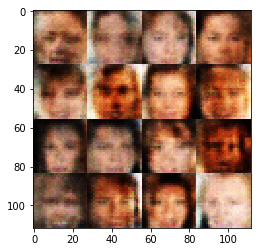

Epoch 1/1	 Discriminator Loss: 1.5891	 Generator Loss: 0.5934
Epoch 1/1	 Discriminator Loss: 1.5050	 Generator Loss: 0.5824
Epoch 1/1	 Discriminator Loss: 1.5515	 Generator Loss: 0.6172
Epoch 1/1	 Discriminator Loss: 1.5475	 Generator Loss: 0.5557
Epoch 1/1	 Discriminator Loss: 1.5263	 Generator Loss: 0.6155
Epoch 1/1	 Discriminator Loss: 1.5180	 Generator Loss: 0.6637
Epoch 1/1	 Discriminator Loss: 1.7005	 Generator Loss: 0.5589
Epoch 1/1	 Discriminator Loss: 1.6244	 Generator Loss: 0.5669
Epoch 1/1	 Discriminator Loss: 1.3993	 Generator Loss: 0.6911
Epoch 1/1	 Discriminator Loss: 1.6492	 Generator Loss: 0.5342
[None, 28, 28, 128]


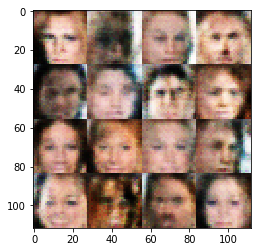

Epoch 1/1	 Discriminator Loss: 1.5066	 Generator Loss: 0.5630
Epoch 1/1	 Discriminator Loss: 1.5102	 Generator Loss: 0.6806
Epoch 1/1	 Discriminator Loss: 1.5624	 Generator Loss: 0.5948
Epoch 1/1	 Discriminator Loss: 1.5993	 Generator Loss: 0.5408
Epoch 1/1	 Discriminator Loss: 1.5737	 Generator Loss: 0.6257
Epoch 1/1	 Discriminator Loss: 1.5823	 Generator Loss: 0.5338
Epoch 1/1	 Discriminator Loss: 1.5406	 Generator Loss: 0.6680
Epoch 1/1	 Discriminator Loss: 1.3656	 Generator Loss: 0.7975
Epoch 1/1	 Discriminator Loss: 1.5414	 Generator Loss: 0.6533
Epoch 1/1	 Discriminator Loss: 1.4510	 Generator Loss: 0.7181
[None, 28, 28, 128]


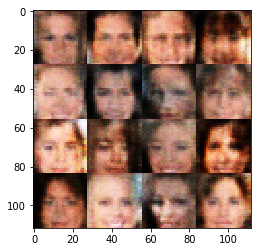

Epoch 1/1	 Discriminator Loss: 1.4314	 Generator Loss: 0.6622
Epoch 1/1	 Discriminator Loss: 1.5515	 Generator Loss: 0.6418
Epoch 1/1	 Discriminator Loss: 1.5645	 Generator Loss: 0.5730
Epoch 1/1	 Discriminator Loss: 1.3502	 Generator Loss: 0.7305
Epoch 1/1	 Discriminator Loss: 1.5012	 Generator Loss: 0.7971
Epoch 1/1	 Discriminator Loss: 1.5510	 Generator Loss: 0.5809
Epoch 1/1	 Discriminator Loss: 1.5356	 Generator Loss: 0.6921
Epoch 1/1	 Discriminator Loss: 1.3969	 Generator Loss: 0.7441
Epoch 1/1	 Discriminator Loss: 1.5745	 Generator Loss: 0.6099
Epoch 1/1	 Discriminator Loss: 1.5015	 Generator Loss: 0.7772
[None, 28, 28, 128]


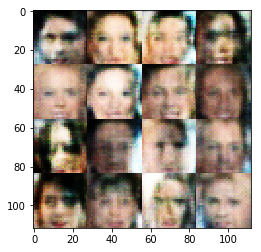

Epoch 1/1	 Discriminator Loss: 1.4841	 Generator Loss: 0.5545
Epoch 1/1	 Discriminator Loss: 1.3322	 Generator Loss: 0.7066
Epoch 1/1	 Discriminator Loss: 1.2212	 Generator Loss: 1.4156
Epoch 1/1	 Discriminator Loss: 1.2721	 Generator Loss: 0.7860
Epoch 1/1	 Discriminator Loss: 1.6156	 Generator Loss: 0.4292
Epoch 1/1	 Discriminator Loss: 1.4136	 Generator Loss: 0.8890
Epoch 1/1	 Discriminator Loss: 1.4365	 Generator Loss: 0.5921
Epoch 1/1	 Discriminator Loss: 1.0470	 Generator Loss: 1.5569
Epoch 1/1	 Discriminator Loss: 1.8764	 Generator Loss: 0.3009
Epoch 1/1	 Discriminator Loss: 1.1884	 Generator Loss: 0.9945
[None, 28, 28, 128]


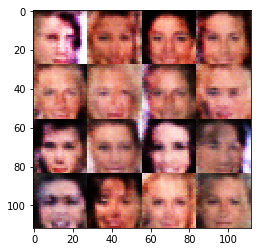

Epoch 1/1	 Discriminator Loss: 1.6997	 Generator Loss: 0.4307
Epoch 1/1	 Discriminator Loss: 1.0339	 Generator Loss: 0.9137
Epoch 1/1	 Discriminator Loss: 1.5290	 Generator Loss: 0.7246
Epoch 1/1	 Discriminator Loss: 1.7110	 Generator Loss: 0.3569
Epoch 1/1	 Discriminator Loss: 1.5022	 Generator Loss: 0.6072
Epoch 1/1	 Discriminator Loss: 0.9497	 Generator Loss: 2.0111
Epoch 1/1	 Discriminator Loss: 1.5506	 Generator Loss: 0.5945
Epoch 1/1	 Discriminator Loss: 1.8746	 Generator Loss: 0.2885
Epoch 1/1	 Discriminator Loss: 1.2148	 Generator Loss: 0.8996
Epoch 1/1	 Discriminator Loss: 1.0384	 Generator Loss: 1.0738
[None, 28, 28, 128]


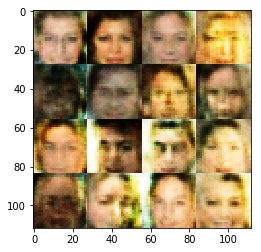

Epoch 1/1	 Discriminator Loss: 1.4153	 Generator Loss: 0.8112
Epoch 1/1	 Discriminator Loss: 1.9147	 Generator Loss: 0.2851
Epoch 1/1	 Discriminator Loss: 1.5831	 Generator Loss: 0.5625
Epoch 1/1	 Discriminator Loss: 1.1945	 Generator Loss: 1.1583
Epoch 1/1	 Discriminator Loss: 1.5472	 Generator Loss: 0.5869
Epoch 1/1	 Discriminator Loss: 1.5828	 Generator Loss: 0.4961
Epoch 1/1	 Discriminator Loss: 1.4023	 Generator Loss: 0.7692
Epoch 1/1	 Discriminator Loss: 1.5252	 Generator Loss: 0.7139
Epoch 1/1	 Discriminator Loss: 1.1961	 Generator Loss: 1.1967
Epoch 1/1	 Discriminator Loss: 1.7963	 Generator Loss: 0.4042
[None, 28, 28, 128]


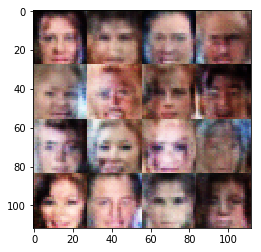

Epoch 1/1	 Discriminator Loss: 1.7669	 Generator Loss: 0.4330
Epoch 1/1	 Discriminator Loss: 1.5610	 Generator Loss: 0.6486
Epoch 1/1	 Discriminator Loss: 1.5166	 Generator Loss: 0.6280
Epoch 1/1	 Discriminator Loss: 1.6403	 Generator Loss: 0.5260
Epoch 1/1	 Discriminator Loss: 1.6248	 Generator Loss: 0.5767
Epoch 1/1	 Discriminator Loss: 1.5774	 Generator Loss: 0.5793
Epoch 1/1	 Discriminator Loss: 1.4851	 Generator Loss: 0.6866
Epoch 1/1	 Discriminator Loss: 1.5526	 Generator Loss: 0.5779
Epoch 1/1	 Discriminator Loss: 1.5238	 Generator Loss: 0.5801
Epoch 1/1	 Discriminator Loss: 1.5523	 Generator Loss: 0.6006
[None, 28, 28, 128]


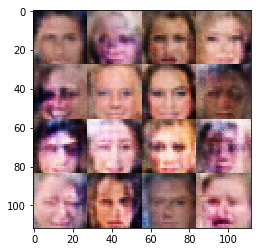

Epoch 1/1	 Discriminator Loss: 1.6993	 Generator Loss: 0.5338
Epoch 1/1	 Discriminator Loss: 1.5446	 Generator Loss: 0.6286
Epoch 1/1	 Discriminator Loss: 1.5809	 Generator Loss: 0.6483
Epoch 1/1	 Discriminator Loss: 1.5291	 Generator Loss: 0.5996
Epoch 1/1	 Discriminator Loss: 1.4885	 Generator Loss: 0.6167
Epoch 1/1	 Discriminator Loss: 1.5549	 Generator Loss: 0.6157
Epoch 1/1	 Discriminator Loss: 1.5085	 Generator Loss: 0.6498
Epoch 1/1	 Discriminator Loss: 1.5652	 Generator Loss: 0.5816
Epoch 1/1	 Discriminator Loss: 1.4518	 Generator Loss: 0.6276
Epoch 1/1	 Discriminator Loss: 1.5317	 Generator Loss: 0.6178
[None, 28, 28, 128]


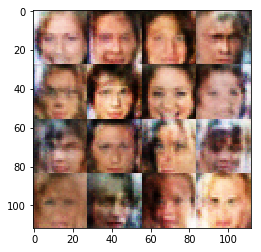

Epoch 1/1	 Discriminator Loss: 1.5057	 Generator Loss: 0.5946
Epoch 1/1	 Discriminator Loss: 1.5568	 Generator Loss: 0.5878
Epoch 1/1	 Discriminator Loss: 1.5294	 Generator Loss: 0.6558
Epoch 1/1	 Discriminator Loss: 1.4794	 Generator Loss: 0.6551
Epoch 1/1	 Discriminator Loss: 1.5337	 Generator Loss: 0.6374
Epoch 1/1	 Discriminator Loss: 1.4662	 Generator Loss: 0.6627
Epoch 1/1	 Discriminator Loss: 1.5790	 Generator Loss: 0.6108
Epoch 1/1	 Discriminator Loss: 1.5057	 Generator Loss: 0.6544
Epoch 1/1	 Discriminator Loss: 1.5737	 Generator Loss: 0.6222
Epoch 1/1	 Discriminator Loss: 1.5896	 Generator Loss: 0.6263
[None, 28, 28, 128]


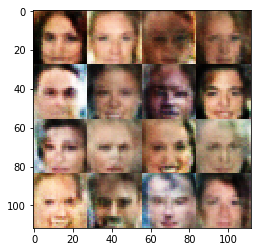

Epoch 1/1	 Discriminator Loss: 1.4933	 Generator Loss: 0.6065
Epoch 1/1	 Discriminator Loss: 1.5330	 Generator Loss: 0.5960
Epoch 1/1	 Discriminator Loss: 1.6085	 Generator Loss: 0.6048
Epoch 1/1	 Discriminator Loss: 1.4951	 Generator Loss: 0.6439
Epoch 1/1	 Discriminator Loss: 1.4765	 Generator Loss: 0.6566
Epoch 1/1	 Discriminator Loss: 1.5427	 Generator Loss: 0.6148
Epoch 1/1	 Discriminator Loss: 1.5361	 Generator Loss: 0.6056
Epoch 1/1	 Discriminator Loss: 1.5696	 Generator Loss: 0.6031
Epoch 1/1	 Discriminator Loss: 1.5464	 Generator Loss: 0.6044
Epoch 1/1	 Discriminator Loss: 1.5523	 Generator Loss: 0.6018
[None, 28, 28, 128]


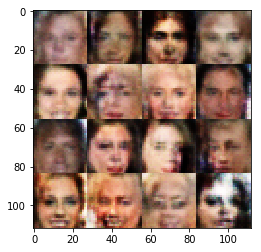

Epoch 1/1	 Discriminator Loss: 1.5064	 Generator Loss: 0.6759
Epoch 1/1	 Discriminator Loss: 1.5433	 Generator Loss: 0.6135
Epoch 1/1	 Discriminator Loss: 1.4908	 Generator Loss: 0.6355
Epoch 1/1	 Discriminator Loss: 1.5772	 Generator Loss: 0.5861
Epoch 1/1	 Discriminator Loss: 1.6314	 Generator Loss: 0.5770
Epoch 1/1	 Discriminator Loss: 1.5253	 Generator Loss: 0.6035
Epoch 1/1	 Discriminator Loss: 1.5884	 Generator Loss: 0.5465
Epoch 1/1	 Discriminator Loss: 1.5725	 Generator Loss: 0.6182
Epoch 1/1	 Discriminator Loss: 1.5274	 Generator Loss: 0.6180
Epoch 1/1	 Discriminator Loss: 1.5213	 Generator Loss: 0.6206
[None, 28, 28, 128]


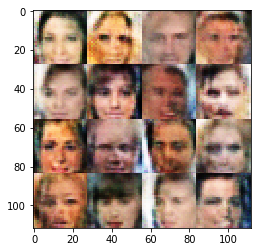

Epoch 1/1	 Discriminator Loss: 1.5601	 Generator Loss: 0.6464
Epoch 1/1	 Discriminator Loss: 1.4374	 Generator Loss: 0.6633
Epoch 1/1	 Discriminator Loss: 1.6093	 Generator Loss: 0.5763
Epoch 1/1	 Discriminator Loss: 1.5773	 Generator Loss: 0.5486
Epoch 1/1	 Discriminator Loss: 1.5377	 Generator Loss: 0.6054
Epoch 1/1	 Discriminator Loss: 1.5019	 Generator Loss: 0.6470
Epoch 1/1	 Discriminator Loss: 1.5497	 Generator Loss: 0.6069
Epoch 1/1	 Discriminator Loss: 1.5204	 Generator Loss: 0.6490
Epoch 1/1	 Discriminator Loss: 1.5259	 Generator Loss: 0.6109
Epoch 1/1	 Discriminator Loss: 1.5712	 Generator Loss: 0.5800
[None, 28, 28, 128]


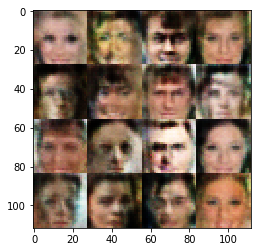

Epoch 1/1	 Discriminator Loss: 1.4864	 Generator Loss: 0.5913
Epoch 1/1	 Discriminator Loss: 1.4767	 Generator Loss: 0.6888
Epoch 1/1	 Discriminator Loss: 1.4868	 Generator Loss: 0.6404
Epoch 1/1	 Discriminator Loss: 1.5227	 Generator Loss: 0.5966
Epoch 1/1	 Discriminator Loss: 1.3992	 Generator Loss: 0.7340
Epoch 1/1	 Discriminator Loss: 1.6252	 Generator Loss: 0.5431
Epoch 1/1	 Discriminator Loss: 1.5887	 Generator Loss: 0.5576
Epoch 1/1	 Discriminator Loss: 1.6078	 Generator Loss: 0.6081
Epoch 1/1	 Discriminator Loss: 1.4816	 Generator Loss: 0.6371
Epoch 1/1	 Discriminator Loss: 1.4401	 Generator Loss: 0.6430
[None, 28, 28, 128]


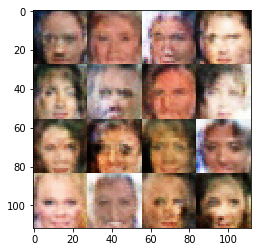

Epoch 1/1	 Discriminator Loss: 1.5419	 Generator Loss: 0.6110
Epoch 1/1	 Discriminator Loss: 1.8421	 Generator Loss: 0.4525
Epoch 1/1	 Discriminator Loss: 1.5553	 Generator Loss: 0.6452
Epoch 1/1	 Discriminator Loss: 1.5789	 Generator Loss: 0.5615
Epoch 1/1	 Discriminator Loss: 1.5188	 Generator Loss: 0.6010
Epoch 1/1	 Discriminator Loss: 1.5341	 Generator Loss: 0.5971
Epoch 1/1	 Discriminator Loss: 1.5129	 Generator Loss: 0.6308
Epoch 1/1	 Discriminator Loss: 1.5121	 Generator Loss: 0.6055
Epoch 1/1	 Discriminator Loss: 1.5351	 Generator Loss: 0.6065
Epoch 1/1	 Discriminator Loss: 1.6593	 Generator Loss: 0.5484
[None, 28, 28, 128]


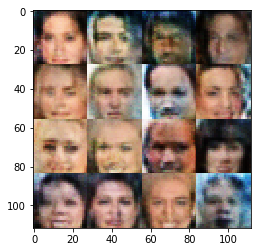

Epoch 1/1	 Discriminator Loss: 1.4620	 Generator Loss: 0.6625
Epoch 1/1	 Discriminator Loss: 1.4572	 Generator Loss: 0.6562
Epoch 1/1	 Discriminator Loss: 1.6449	 Generator Loss: 0.5139
Epoch 1/1	 Discriminator Loss: 1.5585	 Generator Loss: 0.5807
Epoch 1/1	 Discriminator Loss: 1.5227	 Generator Loss: 0.6086
Epoch 1/1	 Discriminator Loss: 1.5107	 Generator Loss: 0.6243
Epoch 1/1	 Discriminator Loss: 1.6717	 Generator Loss: 0.5024
Epoch 1/1	 Discriminator Loss: 1.5619	 Generator Loss: 0.5805
Epoch 1/1	 Discriminator Loss: 1.5535	 Generator Loss: 0.6167
Epoch 1/1	 Discriminator Loss: 1.5305	 Generator Loss: 0.6052
[None, 28, 28, 128]


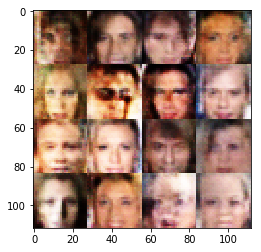

Epoch 1/1	 Discriminator Loss: 1.5746	 Generator Loss: 0.5704
Epoch 1/1	 Discriminator Loss: 1.4892	 Generator Loss: 0.6591
Epoch 1/1	 Discriminator Loss: 1.5238	 Generator Loss: 0.6133
Epoch 1/1	 Discriminator Loss: 1.4704	 Generator Loss: 0.6780
Epoch 1/1	 Discriminator Loss: 1.4828	 Generator Loss: 0.6472
Epoch 1/1	 Discriminator Loss: 1.5117	 Generator Loss: 0.6300
Epoch 1/1	 Discriminator Loss: 1.5599	 Generator Loss: 0.6140
Epoch 1/1	 Discriminator Loss: 1.5679	 Generator Loss: 0.6169
Epoch 1/1	 Discriminator Loss: 1.5600	 Generator Loss: 0.5521
Epoch 1/1	 Discriminator Loss: 1.5370	 Generator Loss: 0.6244
[None, 28, 28, 128]


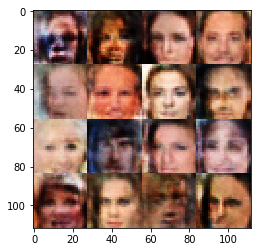

Epoch 1/1	 Discriminator Loss: 1.5476	 Generator Loss: 0.6020
Epoch 1/1	 Discriminator Loss: 1.5806	 Generator Loss: 0.6030
Epoch 1/1	 Discriminator Loss: 1.5456	 Generator Loss: 0.5783
Epoch 1/1	 Discriminator Loss: 1.6015	 Generator Loss: 0.5696
Epoch 1/1	 Discriminator Loss: 1.5688	 Generator Loss: 0.5808
Epoch 1/1	 Discriminator Loss: 1.6466	 Generator Loss: 0.5592
Epoch 1/1	 Discriminator Loss: 1.4844	 Generator Loss: 0.6479
Epoch 1/1	 Discriminator Loss: 1.4270	 Generator Loss: 0.7110
Epoch 1/1	 Discriminator Loss: 1.5694	 Generator Loss: 0.5774
Epoch 1/1	 Discriminator Loss: 1.6143	 Generator Loss: 0.5258
[None, 28, 28, 128]


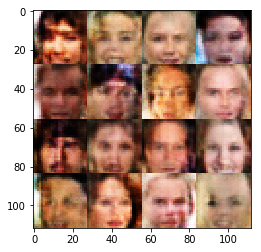

Epoch 1/1	 Discriminator Loss: 1.4438	 Generator Loss: 0.6805
Epoch 1/1	 Discriminator Loss: 1.5715	 Generator Loss: 0.5790
Epoch 1/1	 Discriminator Loss: 1.6065	 Generator Loss: 0.4849
Epoch 1/1	 Discriminator Loss: 1.5669	 Generator Loss: 0.5374
Epoch 1/1	 Discriminator Loss: 1.4333	 Generator Loss: 0.6499
Epoch 1/1	 Discriminator Loss: 1.6376	 Generator Loss: 0.5505
Epoch 1/1	 Discriminator Loss: 1.4905	 Generator Loss: 0.5927
Epoch 1/1	 Discriminator Loss: 1.4901	 Generator Loss: 0.7328
Epoch 1/1	 Discriminator Loss: 1.4433	 Generator Loss: 0.7025
Epoch 1/1	 Discriminator Loss: 1.6088	 Generator Loss: 0.5900
[None, 28, 28, 128]


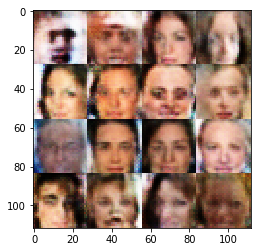

Epoch 1/1	 Discriminator Loss: 1.4353	 Generator Loss: 0.6560
Epoch 1/1	 Discriminator Loss: 1.4984	 Generator Loss: 0.6350
Epoch 1/1	 Discriminator Loss: 1.7057	 Generator Loss: 0.5271
Epoch 1/1	 Discriminator Loss: 1.8469	 Generator Loss: 0.4678
Epoch 1/1	 Discriminator Loss: 1.6080	 Generator Loss: 0.6214
Epoch 1/1	 Discriminator Loss: 1.5177	 Generator Loss: 0.6402
Epoch 1/1	 Discriminator Loss: 1.5444	 Generator Loss: 0.6066
Epoch 1/1	 Discriminator Loss: 1.5149	 Generator Loss: 0.6577
Epoch 1/1	 Discriminator Loss: 1.2678	 Generator Loss: 0.8719
Epoch 1/1	 Discriminator Loss: 1.6469	 Generator Loss: 0.5393
[None, 28, 28, 128]


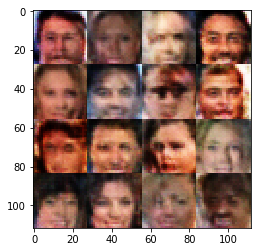

Epoch 1/1	 Discriminator Loss: 1.4970	 Generator Loss: 0.5749
Epoch 1/1	 Discriminator Loss: 1.4562	 Generator Loss: 0.6651
Epoch 1/1	 Discriminator Loss: 1.5535	 Generator Loss: 0.6242
Epoch 1/1	 Discriminator Loss: 1.5274	 Generator Loss: 0.6203
Epoch 1/1	 Discriminator Loss: 1.4969	 Generator Loss: 0.6220
Epoch 1/1	 Discriminator Loss: 1.6537	 Generator Loss: 0.5041
Epoch 1/1	 Discriminator Loss: 1.6066	 Generator Loss: 0.5188
Epoch 1/1	 Discriminator Loss: 1.6484	 Generator Loss: 0.5468
Epoch 1/1	 Discriminator Loss: 1.4954	 Generator Loss: 0.6588
Epoch 1/1	 Discriminator Loss: 1.5588	 Generator Loss: 0.6104
[None, 28, 28, 128]


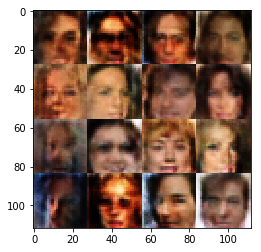

Epoch 1/1	 Discriminator Loss: 1.4339	 Generator Loss: 0.6772
Epoch 1/1	 Discriminator Loss: 1.5673	 Generator Loss: 0.6006
Epoch 1/1	 Discriminator Loss: 1.5156	 Generator Loss: 0.6157
Epoch 1/1	 Discriminator Loss: 1.6801	 Generator Loss: 0.5118
Epoch 1/1	 Discriminator Loss: 1.5605	 Generator Loss: 0.5592
Epoch 1/1	 Discriminator Loss: 1.5207	 Generator Loss: 0.5620
Epoch 1/1	 Discriminator Loss: 1.5594	 Generator Loss: 0.5940
Epoch 1/1	 Discriminator Loss: 1.6166	 Generator Loss: 0.5580
Epoch 1/1	 Discriminator Loss: 1.5957	 Generator Loss: 0.6316
Epoch 1/1	 Discriminator Loss: 1.5377	 Generator Loss: 0.6104
[None, 28, 28, 128]


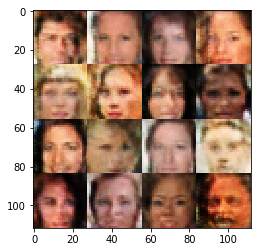

Epoch 1/1	 Discriminator Loss: 1.4740	 Generator Loss: 0.6037
Epoch 1/1	 Discriminator Loss: 1.4119	 Generator Loss: 0.6956
Epoch 1/1	 Discriminator Loss: 1.4805	 Generator Loss: 0.6586
Epoch 1/1	 Discriminator Loss: 1.6800	 Generator Loss: 0.4917
Epoch 1/1	 Discriminator Loss: 1.5671	 Generator Loss: 0.6334
Epoch 1/1	 Discriminator Loss: 1.5708	 Generator Loss: 0.5674
Epoch 1/1	 Discriminator Loss: 1.5814	 Generator Loss: 0.5733
Epoch 1/1	 Discriminator Loss: 1.4750	 Generator Loss: 0.6681
Epoch 1/1	 Discriminator Loss: 1.4422	 Generator Loss: 0.7064
Epoch 1/1	 Discriminator Loss: 1.5178	 Generator Loss: 0.6674
[None, 28, 28, 128]


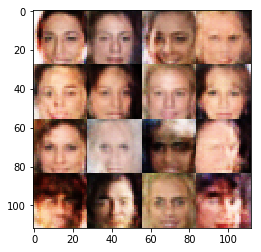

Epoch 1/1	 Discriminator Loss: 1.5551	 Generator Loss: 0.5805
Epoch 1/1	 Discriminator Loss: 1.5855	 Generator Loss: 0.5683
Epoch 1/1	 Discriminator Loss: 1.6803	 Generator Loss: 0.5192
Epoch 1/1	 Discriminator Loss: 1.5773	 Generator Loss: 0.5755
Epoch 1/1	 Discriminator Loss: 1.5492	 Generator Loss: 0.5789
Epoch 1/1	 Discriminator Loss: 1.5056	 Generator Loss: 0.6387
Epoch 1/1	 Discriminator Loss: 1.5596	 Generator Loss: 0.5853
Epoch 1/1	 Discriminator Loss: 1.5483	 Generator Loss: 0.5935
Epoch 1/1	 Discriminator Loss: 1.4457	 Generator Loss: 0.6882
Epoch 1/1	 Discriminator Loss: 1.5245	 Generator Loss: 0.5888
[None, 28, 28, 128]


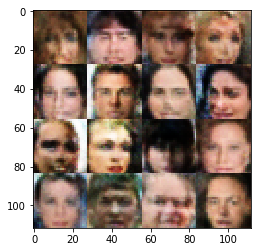

Epoch 1/1	 Discriminator Loss: 1.5156	 Generator Loss: 0.6424
Epoch 1/1	 Discriminator Loss: 1.5185	 Generator Loss: 0.5945
Epoch 1/1	 Discriminator Loss: 1.4759	 Generator Loss: 0.6452
Epoch 1/1	 Discriminator Loss: 1.4500	 Generator Loss: 0.6269
Epoch 1/1	 Discriminator Loss: 1.3847	 Generator Loss: 0.7057
Epoch 1/1	 Discriminator Loss: 1.5435	 Generator Loss: 0.6302
Epoch 1/1	 Discriminator Loss: 1.5668	 Generator Loss: 0.5857
Epoch 1/1	 Discriminator Loss: 1.5040	 Generator Loss: 0.6287
Epoch 1/1	 Discriminator Loss: 1.6130	 Generator Loss: 0.5647
Epoch 1/1	 Discriminator Loss: 1.4918	 Generator Loss: 0.6109
[None, 28, 28, 128]


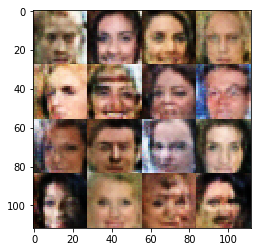

Epoch 1/1	 Discriminator Loss: 1.6169	 Generator Loss: 0.5451
Epoch 1/1	 Discriminator Loss: 1.4799	 Generator Loss: 0.6411
Epoch 1/1	 Discriminator Loss: 1.5088	 Generator Loss: 0.6116
Epoch 1/1	 Discriminator Loss: 1.5345	 Generator Loss: 0.6320
Epoch 1/1	 Discriminator Loss: 1.5149	 Generator Loss: 0.6395
Epoch 1/1	 Discriminator Loss: 1.4541	 Generator Loss: 0.6264
Epoch 1/1	 Discriminator Loss: 1.7175	 Generator Loss: 0.4852
Epoch 1/1	 Discriminator Loss: 1.5484	 Generator Loss: 0.5960
Epoch 1/1	 Discriminator Loss: 1.5298	 Generator Loss: 0.6119
Epoch 1/1	 Discriminator Loss: 1.4961	 Generator Loss: 0.6158
[None, 28, 28, 128]


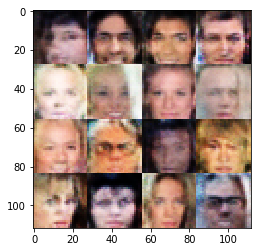

Epoch 1/1	 Discriminator Loss: 1.5392	 Generator Loss: 0.6020
Epoch 1/1	 Discriminator Loss: 1.5510	 Generator Loss: 0.5852
Epoch 1/1	 Discriminator Loss: 1.5851	 Generator Loss: 0.5742
Epoch 1/1	 Discriminator Loss: 1.6218	 Generator Loss: 0.5799
Epoch 1/1	 Discriminator Loss: 1.3941	 Generator Loss: 0.7086
Epoch 1/1	 Discriminator Loss: 1.3709	 Generator Loss: 0.7570
Epoch 1/1	 Discriminator Loss: 1.5501	 Generator Loss: 0.5994
Epoch 1/1	 Discriminator Loss: 1.5148	 Generator Loss: 0.6344
Epoch 1/1	 Discriminator Loss: 1.4220	 Generator Loss: 0.6703
Epoch 1/1	 Discriminator Loss: 1.5037	 Generator Loss: 0.6400
[None, 28, 28, 128]


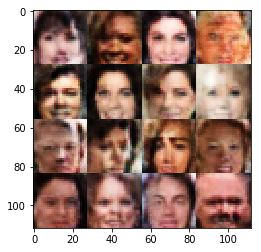

Epoch 1/1	 Discriminator Loss: 1.5678	 Generator Loss: 0.5593
Epoch 1/1	 Discriminator Loss: 1.5508	 Generator Loss: 0.5820
Epoch 1/1	 Discriminator Loss: 1.5861	 Generator Loss: 0.5654
Epoch 1/1	 Discriminator Loss: 1.5302	 Generator Loss: 0.6397
Epoch 1/1	 Discriminator Loss: 1.5719	 Generator Loss: 0.5705
Epoch 1/1	 Discriminator Loss: 1.4826	 Generator Loss: 0.6458
Epoch 1/1	 Discriminator Loss: 1.5054	 Generator Loss: 0.6198
Epoch 1/1	 Discriminator Loss: 1.4259	 Generator Loss: 0.6664
Epoch 1/1	 Discriminator Loss: 1.5104	 Generator Loss: 0.6444
Epoch 1/1	 Discriminator Loss: 1.7653	 Generator Loss: 0.4884
[None, 28, 28, 128]


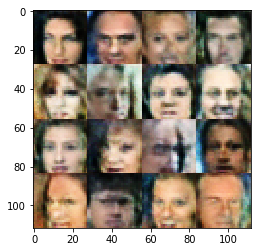

Epoch 1/1	 Discriminator Loss: 1.4973	 Generator Loss: 0.6648
Epoch 1/1	 Discriminator Loss: 1.4621	 Generator Loss: 0.6669
Epoch 1/1	 Discriminator Loss: 1.5972	 Generator Loss: 0.5842
Epoch 1/1	 Discriminator Loss: 1.4985	 Generator Loss: 0.6811
Epoch 1/1	 Discriminator Loss: 1.4840	 Generator Loss: 0.7004
Epoch 1/1	 Discriminator Loss: 1.5058	 Generator Loss: 0.6265
Epoch 1/1	 Discriminator Loss: 1.4650	 Generator Loss: 0.6416
Epoch 1/1	 Discriminator Loss: 1.5128	 Generator Loss: 0.6070
Epoch 1/1	 Discriminator Loss: 1.6176	 Generator Loss: 0.5921
Epoch 1/1	 Discriminator Loss: 1.4171	 Generator Loss: 0.6732
[None, 28, 28, 128]


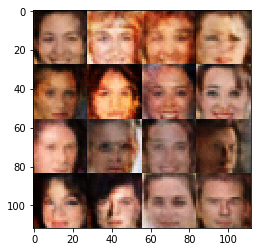

Epoch 1/1	 Discriminator Loss: 1.5174	 Generator Loss: 0.6219
Epoch 1/1	 Discriminator Loss: 1.6855	 Generator Loss: 0.5581
Epoch 1/1	 Discriminator Loss: 1.5371	 Generator Loss: 0.6381
Epoch 1/1	 Discriminator Loss: 1.6084	 Generator Loss: 0.5506
Epoch 1/1	 Discriminator Loss: 1.5311	 Generator Loss: 0.5984
Epoch 1/1	 Discriminator Loss: 1.5541	 Generator Loss: 0.5953
Epoch 1/1	 Discriminator Loss: 1.5210	 Generator Loss: 0.6142
Epoch 1/1	 Discriminator Loss: 1.4532	 Generator Loss: 0.6502
Epoch 1/1	 Discriminator Loss: 1.6008	 Generator Loss: 0.5509
Epoch 1/1	 Discriminator Loss: 1.5541	 Generator Loss: 0.6111
[None, 28, 28, 128]


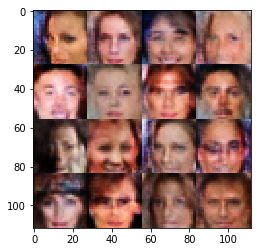

Epoch 1/1	 Discriminator Loss: 1.3946	 Generator Loss: 0.7267
Epoch 1/1	 Discriminator Loss: 1.4476	 Generator Loss: 0.6474
Epoch 1/1	 Discriminator Loss: 1.5726	 Generator Loss: 0.5878
Epoch 1/1	 Discriminator Loss: 1.4764	 Generator Loss: 0.6718
Epoch 1/1	 Discriminator Loss: 1.6367	 Generator Loss: 0.5244
Epoch 1/1	 Discriminator Loss: 1.6875	 Generator Loss: 0.5443
Epoch 1/1	 Discriminator Loss: 1.5706	 Generator Loss: 0.6127
Epoch 1/1	 Discriminator Loss: 1.6402	 Generator Loss: 0.5712
Epoch 1/1	 Discriminator Loss: 1.5113	 Generator Loss: 0.6258
Epoch 1/1	 Discriminator Loss: 1.5069	 Generator Loss: 0.6314
[None, 28, 28, 128]


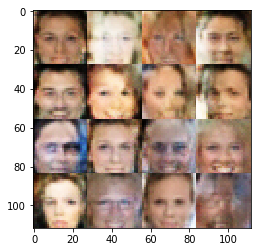

Epoch 1/1	 Discriminator Loss: 1.4954	 Generator Loss: 0.6535
Epoch 1/1	 Discriminator Loss: 1.5413	 Generator Loss: 0.5770
Epoch 1/1	 Discriminator Loss: 1.5096	 Generator Loss: 0.6717
Epoch 1/1	 Discriminator Loss: 1.4625	 Generator Loss: 0.6393
Epoch 1/1	 Discriminator Loss: 1.5365	 Generator Loss: 0.5925
Epoch 1/1	 Discriminator Loss: 1.5546	 Generator Loss: 0.5968
Epoch 1/1	 Discriminator Loss: 1.4645	 Generator Loss: 0.6771
Epoch 1/1	 Discriminator Loss: 1.6233	 Generator Loss: 0.5678
Epoch 1/1	 Discriminator Loss: 1.6525	 Generator Loss: 0.5606
Epoch 1/1	 Discriminator Loss: 1.4632	 Generator Loss: 0.6520
[None, 28, 28, 128]


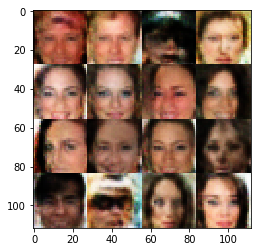

Epoch 1/1	 Discriminator Loss: 1.6404	 Generator Loss: 0.5483
Epoch 1/1	 Discriminator Loss: 1.5628	 Generator Loss: 0.6139
Epoch 1/1	 Discriminator Loss: 1.5729	 Generator Loss: 0.5814
Epoch 1/1	 Discriminator Loss: 1.5858	 Generator Loss: 0.5954
Epoch 1/1	 Discriminator Loss: 1.6570	 Generator Loss: 0.5288
Epoch 1/1	 Discriminator Loss: 1.5667	 Generator Loss: 0.5916
Epoch 1/1	 Discriminator Loss: 1.5645	 Generator Loss: 0.6029
Epoch 1/1	 Discriminator Loss: 1.5423	 Generator Loss: 0.6093
Epoch 1/1	 Discriminator Loss: 1.4960	 Generator Loss: 0.6405
Epoch 1/1	 Discriminator Loss: 1.5473	 Generator Loss: 0.5786
[None, 28, 28, 128]


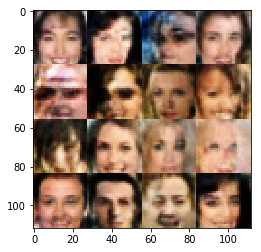

Epoch 1/1	 Discriminator Loss: 1.5772	 Generator Loss: 0.5745
Epoch 1/1	 Discriminator Loss: 1.5179	 Generator Loss: 0.6131
Epoch 1/1	 Discriminator Loss: 1.5577	 Generator Loss: 0.5770
Epoch 1/1	 Discriminator Loss: 1.4486	 Generator Loss: 0.6863
Epoch 1/1	 Discriminator Loss: 1.5925	 Generator Loss: 0.5424
Epoch 1/1	 Discriminator Loss: 1.6016	 Generator Loss: 0.5478
Epoch 1/1	 Discriminator Loss: 1.6253	 Generator Loss: 0.5765
Epoch 1/1	 Discriminator Loss: 1.4682	 Generator Loss: 0.6351
Epoch 1/1	 Discriminator Loss: 1.5359	 Generator Loss: 0.6059
Epoch 1/1	 Discriminator Loss: 1.5297	 Generator Loss: 0.5993
[None, 28, 28, 128]


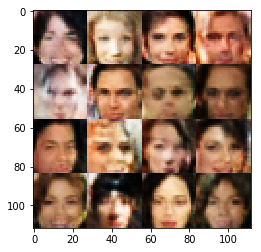

Epoch 1/1	 Discriminator Loss: 1.5354	 Generator Loss: 0.5901
Epoch 1/1	 Discriminator Loss: 1.4935	 Generator Loss: 0.6969
Epoch 1/1	 Discriminator Loss: 1.5711	 Generator Loss: 0.5842
Epoch 1/1	 Discriminator Loss: 1.5172	 Generator Loss: 0.6110
Epoch 1/1	 Discriminator Loss: 1.5142	 Generator Loss: 0.6057
Epoch 1/1	 Discriminator Loss: 1.4280	 Generator Loss: 0.6971
Epoch 1/1	 Discriminator Loss: 1.3959	 Generator Loss: 0.6995
Epoch 1/1	 Discriminator Loss: 1.4997	 Generator Loss: 0.6374
Epoch 1/1	 Discriminator Loss: 1.6064	 Generator Loss: 0.5607
Epoch 1/1	 Discriminator Loss: 1.4871	 Generator Loss: 0.6385
[None, 28, 28, 128]


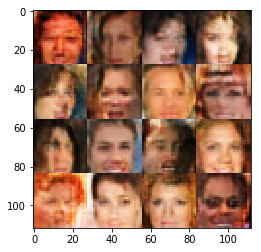

Epoch 1/1	 Discriminator Loss: 1.4935	 Generator Loss: 0.6414
Epoch 1/1	 Discriminator Loss: 1.4894	 Generator Loss: 0.6162
Epoch 1/1	 Discriminator Loss: 1.2711	 Generator Loss: 0.8047
Epoch 1/1	 Discriminator Loss: 1.4711	 Generator Loss: 0.6321
Epoch 1/1	 Discriminator Loss: 1.4567	 Generator Loss: 0.6927
Epoch 1/1	 Discriminator Loss: 1.4956	 Generator Loss: 0.6628
Epoch 1/1	 Discriminator Loss: 1.5670	 Generator Loss: 0.6103
Epoch 1/1	 Discriminator Loss: 1.5070	 Generator Loss: 0.5976
Epoch 1/1	 Discriminator Loss: 1.5721	 Generator Loss: 0.5893
Epoch 1/1	 Discriminator Loss: 1.5790	 Generator Loss: 0.5945
[None, 28, 28, 128]


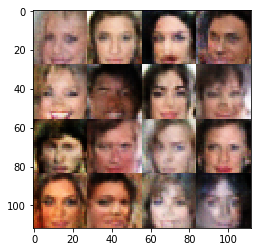

Epoch 1/1	 Discriminator Loss: 1.5774	 Generator Loss: 0.6173
Epoch 1/1	 Discriminator Loss: 1.5754	 Generator Loss: 0.6088
Epoch 1/1	 Discriminator Loss: 1.5733	 Generator Loss: 0.6102
Epoch 1/1	 Discriminator Loss: 1.4953	 Generator Loss: 0.6675
Epoch 1/1	 Discriminator Loss: 1.5090	 Generator Loss: 0.6336
Epoch 1/1	 Discriminator Loss: 1.5166	 Generator Loss: 0.6532
Epoch 1/1	 Discriminator Loss: 1.5071	 Generator Loss: 0.6237
Epoch 1/1	 Discriminator Loss: 1.5416	 Generator Loss: 0.6060
Epoch 1/1	 Discriminator Loss: 1.5713	 Generator Loss: 0.6223
Epoch 1/1	 Discriminator Loss: 1.5168	 Generator Loss: 0.5455
[None, 28, 28, 128]


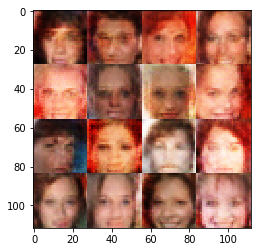

Epoch 1/1	 Discriminator Loss: 1.5717	 Generator Loss: 0.6257
Epoch 1/1	 Discriminator Loss: 1.4555	 Generator Loss: 0.6592
Epoch 1/1	 Discriminator Loss: 1.6031	 Generator Loss: 0.5890
Epoch 1/1	 Discriminator Loss: 1.6792	 Generator Loss: 0.5108
Epoch 1/1	 Discriminator Loss: 1.4199	 Generator Loss: 0.7162
Epoch 1/1	 Discriminator Loss: 1.7309	 Generator Loss: 0.4878
Epoch 1/1	 Discriminator Loss: 1.5308	 Generator Loss: 0.6525
Epoch 1/1	 Discriminator Loss: 1.4977	 Generator Loss: 0.6350
Epoch 1/1	 Discriminator Loss: 1.4577	 Generator Loss: 0.6576
Epoch 1/1	 Discriminator Loss: 1.6184	 Generator Loss: 0.5527
[None, 28, 28, 128]


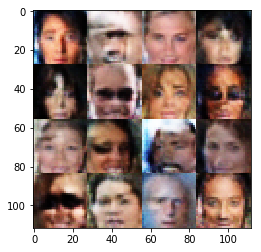

Epoch 1/1	 Discriminator Loss: 1.5517	 Generator Loss: 0.5941
Epoch 1/1	 Discriminator Loss: 1.5246	 Generator Loss: 0.6067
Epoch 1/1	 Discriminator Loss: 1.5300	 Generator Loss: 0.5790
Epoch 1/1	 Discriminator Loss: 1.5356	 Generator Loss: 0.6308
Epoch 1/1	 Discriminator Loss: 1.4661	 Generator Loss: 0.6688
Epoch 1/1	 Discriminator Loss: 1.5895	 Generator Loss: 0.5362
Epoch 1/1	 Discriminator Loss: 1.4788	 Generator Loss: 0.6707
Epoch 1/1	 Discriminator Loss: 1.5816	 Generator Loss: 0.5778
Epoch 1/1	 Discriminator Loss: 1.5540	 Generator Loss: 0.5720
Epoch 1/1	 Discriminator Loss: 1.4590	 Generator Loss: 0.6648
[None, 28, 28, 128]


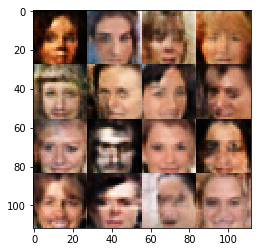

Epoch 1/1	 Discriminator Loss: 1.4706	 Generator Loss: 0.6591
Epoch 1/1	 Discriminator Loss: 1.6406	 Generator Loss: 0.5615
Epoch 1/1	 Discriminator Loss: 1.5845	 Generator Loss: 0.5735
Epoch 1/1	 Discriminator Loss: 1.5546	 Generator Loss: 0.6242
Epoch 1/1	 Discriminator Loss: 1.6083	 Generator Loss: 0.5764
Epoch 1/1	 Discriminator Loss: 1.6458	 Generator Loss: 0.5178
Epoch 1/1	 Discriminator Loss: 1.5293	 Generator Loss: 0.6073
Epoch 1/1	 Discriminator Loss: 1.5497	 Generator Loss: 0.6290
Epoch 1/1	 Discriminator Loss: 1.5675	 Generator Loss: 0.5670
Epoch 1/1	 Discriminator Loss: 1.5043	 Generator Loss: 0.6185
[None, 28, 28, 128]


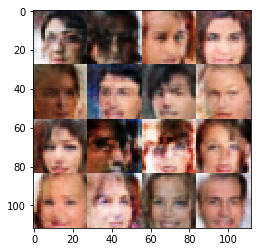

Epoch 1/1	 Discriminator Loss: 1.5319	 Generator Loss: 0.6125
Epoch 1/1	 Discriminator Loss: 1.6322	 Generator Loss: 0.5641
Epoch 1/1	 Discriminator Loss: 1.5730	 Generator Loss: 0.5577
Epoch 1/1	 Discriminator Loss: 1.4528	 Generator Loss: 0.6535
Epoch 1/1	 Discriminator Loss: 1.4699	 Generator Loss: 0.6478
Epoch 1/1	 Discriminator Loss: 1.5454	 Generator Loss: 0.5745
Epoch 1/1	 Discriminator Loss: 1.6051	 Generator Loss: 0.5676
Epoch 1/1	 Discriminator Loss: 1.4629	 Generator Loss: 0.6689
Epoch 1/1	 Discriminator Loss: 1.4396	 Generator Loss: 0.6862
Epoch 1/1	 Discriminator Loss: 1.5682	 Generator Loss: 0.5657
[None, 28, 28, 128]


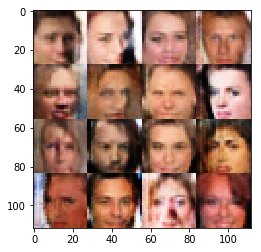

Epoch 1/1	 Discriminator Loss: 1.6207	 Generator Loss: 0.5316
Epoch 1/1	 Discriminator Loss: 1.4603	 Generator Loss: 0.6703
Epoch 1/1	 Discriminator Loss: 1.6009	 Generator Loss: 0.5667
Epoch 1/1	 Discriminator Loss: 1.5453	 Generator Loss: 0.6175
Epoch 1/1	 Discriminator Loss: 1.4921	 Generator Loss: 0.6255
Epoch 1/1	 Discriminator Loss: 1.5766	 Generator Loss: 0.5405
Epoch 1/1	 Discriminator Loss: 1.5116	 Generator Loss: 0.6262
Epoch 1/1	 Discriminator Loss: 1.5330	 Generator Loss: 0.6111
Epoch 1/1	 Discriminator Loss: 1.5449	 Generator Loss: 0.6029
Epoch 1/1	 Discriminator Loss: 1.4153	 Generator Loss: 0.6974
[None, 28, 28, 128]


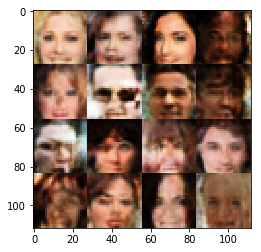

Epoch 1/1	 Discriminator Loss: 1.5107	 Generator Loss: 0.6371
Epoch 1/1	 Discriminator Loss: 1.4607	 Generator Loss: 0.6266
Epoch 1/1	 Discriminator Loss: 1.5769	 Generator Loss: 0.6088
Epoch 1/1	 Discriminator Loss: 1.5250	 Generator Loss: 0.6204
Epoch 1/1	 Discriminator Loss: 1.5583	 Generator Loss: 0.6283
Epoch 1/1	 Discriminator Loss: 1.4547	 Generator Loss: 0.7008
Epoch 1/1	 Discriminator Loss: 1.5081	 Generator Loss: 0.6206
Epoch 1/1	 Discriminator Loss: 1.4938	 Generator Loss: 0.6127
Epoch 1/1	 Discriminator Loss: 1.4361	 Generator Loss: 0.6446
Epoch 1/1	 Discriminator Loss: 1.5370	 Generator Loss: 0.5916
[None, 28, 28, 128]


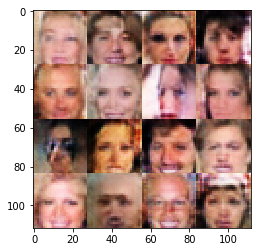

Epoch 1/1	 Discriminator Loss: 1.5298	 Generator Loss: 0.6600
Epoch 1/1	 Discriminator Loss: 1.4977	 Generator Loss: 0.6372
Epoch 1/1	 Discriminator Loss: 1.5004	 Generator Loss: 0.6309
Epoch 1/1	 Discriminator Loss: 1.5123	 Generator Loss: 0.6170
Epoch 1/1	 Discriminator Loss: 1.4806	 Generator Loss: 0.6033
Epoch 1/1	 Discriminator Loss: 1.4895	 Generator Loss: 0.6627
Epoch 1/1	 Discriminator Loss: 1.4903	 Generator Loss: 0.6252
Epoch 1/1	 Discriminator Loss: 1.6415	 Generator Loss: 0.5549
Epoch 1/1	 Discriminator Loss: 1.5610	 Generator Loss: 0.5784
Epoch 1/1	 Discriminator Loss: 1.5350	 Generator Loss: 0.5898
[None, 28, 28, 128]


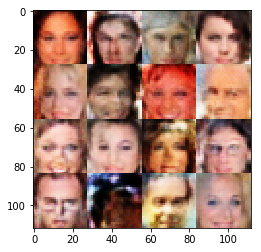

Epoch 1/1	 Discriminator Loss: 1.4997	 Generator Loss: 0.6339
Epoch 1/1	 Discriminator Loss: 1.5641	 Generator Loss: 0.5758


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.